# MMHS150K Dataset — Exploratory Data Analysis

**Dataset:** Multimodal Hate Speech (MMHS150K) — Twitter posts with images and text  
**Labels:** 0=NotHate, 1=Racist, 2=Sexist, 3=Homophobe, 4=Religion, 5=OtherHate  
**Structure:** Each tweet has 3 independent AMT annotator labels

In [1]:
import json
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

warnings.filterwarnings('ignore')
nltk.download('stopwords', quiet=True)

# ── Paths ──────────────────────────────────────────────────────────────
BASE     = '/Users/sankalpssss/Desktop/Keerthan_thesis/Code/data'
GT_PATH  = os.path.join(BASE, 'MMHS150K_GT.json')
SPLIT_DIR= os.path.join(BASE, 'splits')
IMG_TXT  = os.path.join(BASE, 'img_txt')
IMG_DIR  = os.path.join(BASE, 'img_resized')
OUT_DIR  = '/Users/sankalpssss/Desktop/Keerthan_thesis/Code/EDA'

LABEL_MAP = {0:'NotHate', 1:'Racist', 2:'Sexist', 3:'Homophobe', 4:'Religion', 5:'OtherHate'}
COLORS    = ['#4CAF50','#F44336','#FF9800','#9C27B0','#2196F3','#FF5722']

sns.set_theme(style='whitegrid', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120

## 1. Load Data

In [3]:
# ── Load ground-truth ──────────────────────────────────────────────────
with open(GT_PATH) as f:
    raw = json.load(f)

records = []
for tweet_id, v in raw.items():
    labels = v['labels']          # list of 1-3 ints
    # Pad to 3 with last value if shorter
    while len(labels) < 3:
        labels = labels + [labels[-1]] if labels else [0, 0, 0]
    records.append({
        'tweet_id'  : tweet_id,
        'tweet_text': v.get('tweet_text', ''),
        'label_0'   : labels[0],
        'label_1'   : labels[1],
        'label_2'   : labels[2],
        'labels_str': v.get('labels_str', []),
    })

df = pd.DataFrame(records)

# Majority vote label
def majority_label(row):
    counts = Counter([row['label_0'], row['label_1'], row['label_2']])
    return counts.most_common(1)[0][0]

df['majority_label'] = df.apply(majority_label, axis=1)
df['majority_label_str'] = df['majority_label'].map(LABEL_MAP)

# Is hate? (majority != 0)
df['is_hate'] = df['majority_label'] != 0

# Text length
df['text_len'] = df['tweet_text'].str.len()
df['word_count'] = df['tweet_text'].str.split().str.len()

# Load splits
splits = {}
for split in ['train', 'val', 'test']:
    with open(os.path.join(SPLIT_DIR, f'{split}_ids.txt')) as f:
        splits[split] = set(f.read().splitlines())

def assign_split(tid):
    if tid in splits['train']: return 'train'
    if tid in splits['val']:   return 'val'
    if tid in splits['test']:  return 'test'
    return 'unknown'

df['split'] = df['tweet_id'].apply(assign_split)

# OCR text availability
ocr_ids = set(f.replace('.json','') for f in os.listdir(IMG_TXT) if f.endswith('.json'))
df['has_ocr'] = df['tweet_id'].isin(ocr_ids)

# Image availability
img_ids = set(f.split('.')[0] for f in os.listdir(IMG_DIR))
df['has_image'] = df['tweet_id'].isin(img_ids)

print(f'Total tweets : {len(df):,}')
print(f'Hate tweets  : {df["is_hate"].sum():,} ({df["is_hate"].mean()*100:.1f}%)')
print(f'Non-hate     : {(~df["is_hate"]).sum():,} ({(~df["is_hate"]).mean()*100:.1f}%)')
print(f'Tweets with image : {df["has_image"].sum():,}')
print(f'Tweets with OCR   : {df["has_ocr"].sum():,}')
df.head(3)

Total tweets : 149,823
Hate tweets  : 33,034 (22.0%)
Non-hate     : 116,789 (78.0%)
Tweets with image : 149,823
Tweets with OCR   : 59,252


,tweet_id,tweet_text,label_0,label_1,label_2,labels_str,majority_label,majority_label_str,is_hate,text_len,word_count,split,has_ocr,has_image
0,1114679353714016256,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,4,1,3,"[Religion, Racist, Homophobe]",4,Religion,True,44,3,train,True,True
1,1063020048816660480,My horses are retarded https://t.co/HYhqc6d5WN,5,5,5,"[OtherHate, OtherHate, OtherHate]",5,OtherHate,True,46,5,train,False,True
2,1108927368075374593,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,0,0,0,"[NotHate, NotHate, NotHate]",0,NotHate,False,80,11,train,False,True


## 2. Dataset Split & Class Balance

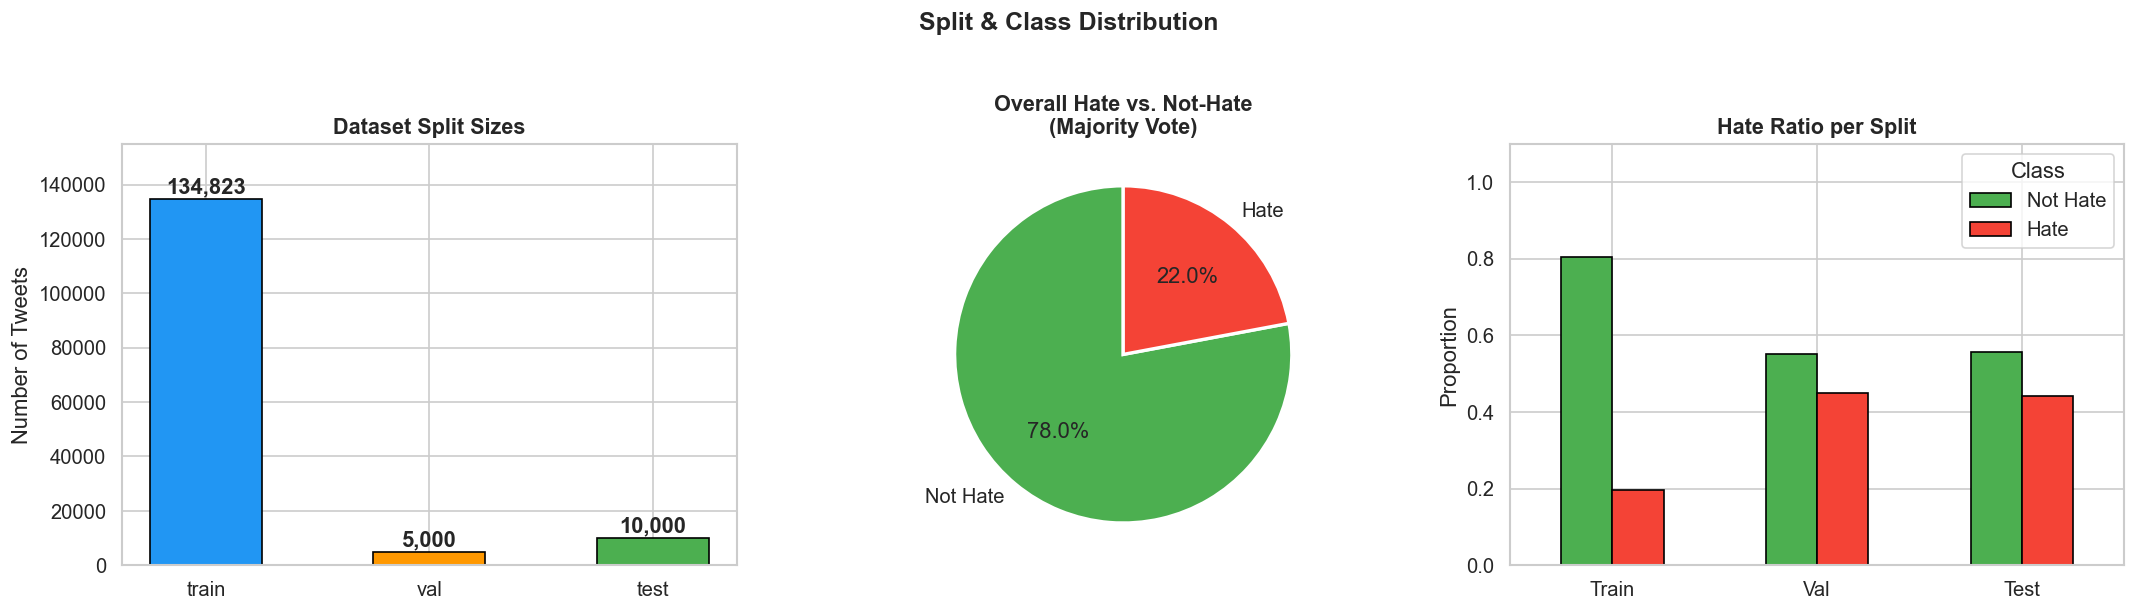

Saved → split_class_distribution.png


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ── (A) Train / Val / Test split sizes ────────────────────────────────
split_counts = df['split'].value_counts().reindex(['train','val','test'])
bars = axes[0].bar(split_counts.index, split_counts.values,
                   color=['#2196F3','#FF9800','#4CAF50'], width=0.5, edgecolor='black')
for bar, val in zip(bars, split_counts.values):
    axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+500,
                 f'{val:,}', ha='center', va='bottom', fontweight='bold')
axes[0].set_title('Dataset Split Sizes', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Tweets')
axes[0].set_ylim(0, split_counts.max()*1.15)

# ── (B) Hate vs Not-Hate (overall) ────────────────────────────────────
hate_counts = df['is_hate'].value_counts()
axes[1].pie([hate_counts[False], hate_counts[True]],
            labels=['Not Hate', 'Hate'],
            colors=['#4CAF50','#F44336'],
            autopct='%1.1f%%', startangle=90,
            wedgeprops={'edgecolor':'white','linewidth':2})
axes[1].set_title('Overall Hate vs. Not-Hate\n(Majority Vote)', fontsize=13, fontweight='bold')

# ── (C) Hate/Not-Hate per split ───────────────────────────────────────
split_hate = df.groupby('split')['is_hate'].value_counts(normalize=True).unstack()
split_hate = split_hate.reindex(['train','val','test'])
split_hate.plot(kind='bar', ax=axes[2], color=['#4CAF50','#F44336'],
                width=0.5, edgecolor='black')
axes[2].set_title('Hate Ratio per Split', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Proportion')
axes[2].set_xlabel('')
axes[2].set_xticklabels(['Train','Val','Test'], rotation=0)
axes[2].legend(['Not Hate','Hate'], title='Class')
axes[2].set_ylim(0, 1.1)

plt.suptitle('Split & Class Distribution', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'split_class_distribution.png'), bbox_inches='tight')
plt.show()
print('Saved → split_class_distribution.png')

## 3. Hate Speech Category Distribution

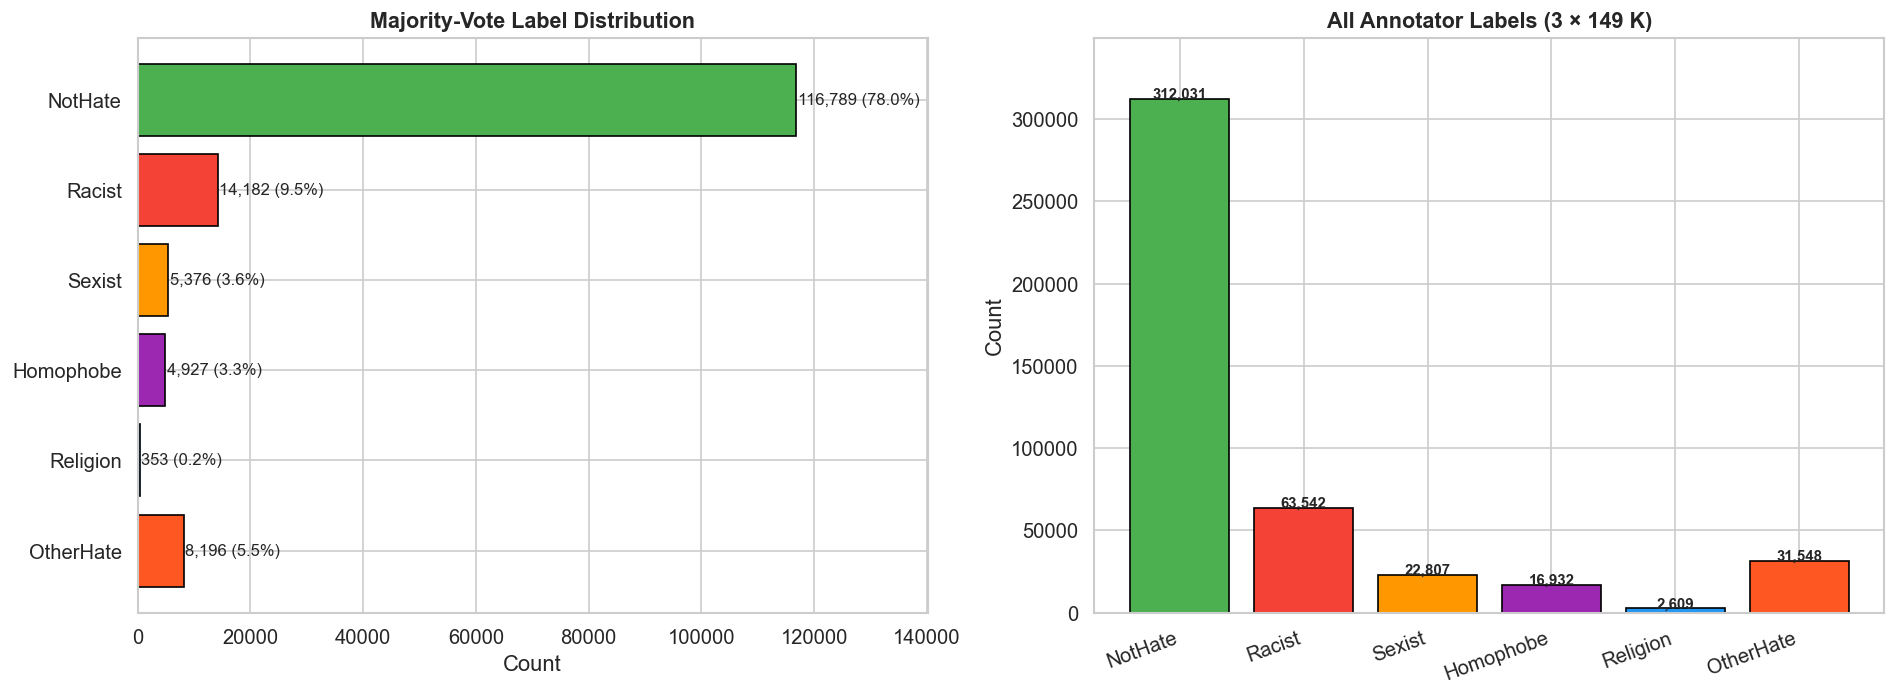

Saved → label_distribution.png


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ── (A) Majority label counts ─────────────────────────────────────────
maj_counts = df['majority_label_str'].value_counts().reindex(
    [LABEL_MAP[i] for i in range(6)])
bars = axes[0].barh(maj_counts.index[::-1], maj_counts.values[::-1],
                    color=COLORS[::-1], edgecolor='black')
for bar, val in zip(bars, maj_counts.values[::-1]):
    axes[0].text(bar.get_width()+300, bar.get_y()+bar.get_height()/2,
                 f'{val:,} ({val/len(df)*100:.1f}%)',
                 va='center', fontsize=10)
axes[0].set_title('Majority-Vote Label Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Count')
axes[0].set_xlim(0, maj_counts.max()*1.2)

# ── (B) ALL annotator labels (flattened) ──────────────────────────────
all_labels = pd.concat([
    df['label_0'], df['label_1'], df['label_2']
]).map(LABEL_MAP).value_counts().reindex([LABEL_MAP[i] for i in range(6)])

axes[1].bar(all_labels.index, all_labels.values,
            color=COLORS, edgecolor='black')
for i, (idx, val) in enumerate(all_labels.items()):
    axes[1].text(i, val+500, f'{val:,}', ha='center', fontsize=9, fontweight='bold')
axes[1].set_title('All Annotator Labels (3 × 149 K)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(all_labels.index, rotation=20, ha='right')
axes[1].set_ylim(0, all_labels.max()*1.12)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'label_distribution.png'), bbox_inches='tight')
plt.show()
print('Saved → label_distribution.png')

## 4. Inter-Annotator Agreement

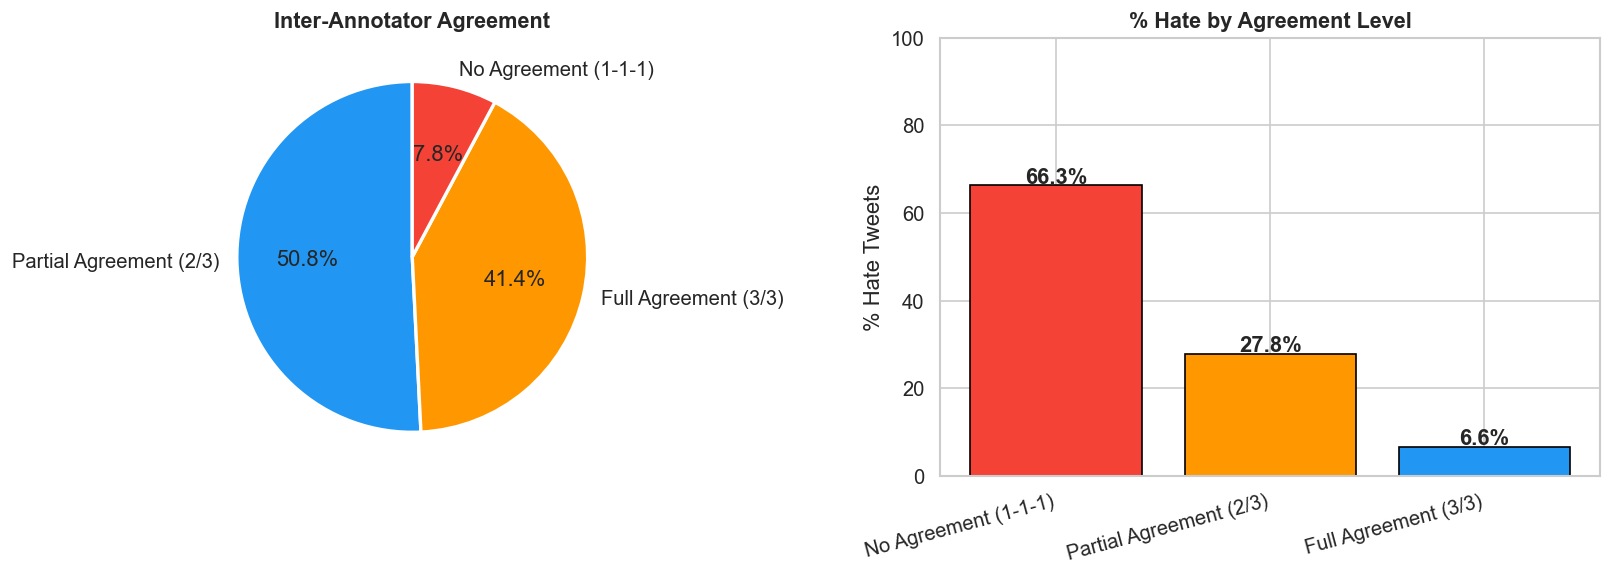

agreement
Partial Agreement (2/3)    76097
Full Agreement (3/3)       62027
No Agreement (1-1-1)       11699
Saved → annotator_agreement.png


In [6]:
def agreement_level(row):
    vals = [row['label_0'], row['label_1'], row['label_2']]
    if len(set(vals)) == 1: return 'Full Agreement (3/3)'
    counts = Counter(vals)
    if counts.most_common(1)[0][1] == 2: return 'Partial Agreement (2/3)'
    return 'No Agreement (1-1-1)'

df['agreement'] = df.apply(agreement_level, axis=1)

agree_counts = df['agreement'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie
axes[0].pie(agree_counts.values,
            labels=agree_counts.index,
            autopct='%1.1f%%',
            colors=['#2196F3','#FF9800','#F44336'],
            startangle=90,
            wedgeprops={'edgecolor':'white','linewidth':2})
axes[0].set_title('Inter-Annotator Agreement', fontsize=13, fontweight='bold')

# Agreement × hate/not-hate
agree_hate = df.groupby('agreement')['is_hate'].mean().sort_values(ascending=False)
axes[1].bar(agree_hate.index, agree_hate.values*100,
            color=['#F44336','#FF9800','#2196F3'][:len(agree_hate)], edgecolor='black')
for i, val in enumerate(agree_hate.values):
    axes[1].text(i, val*100+0.5, f'{val*100:.1f}%', ha='center', fontweight='bold')
axes[1].set_title('% Hate by Agreement Level', fontsize=13, fontweight='bold')
axes[1].set_ylabel('% Hate Tweets')
axes[1].set_xticklabels(agree_hate.index, rotation=15, ha='right')
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'annotator_agreement.png'), bbox_inches='tight')
plt.show()

print(agree_counts.to_string())
print('Saved → annotator_agreement.png')

## 5. Tweet Text Length Analysis

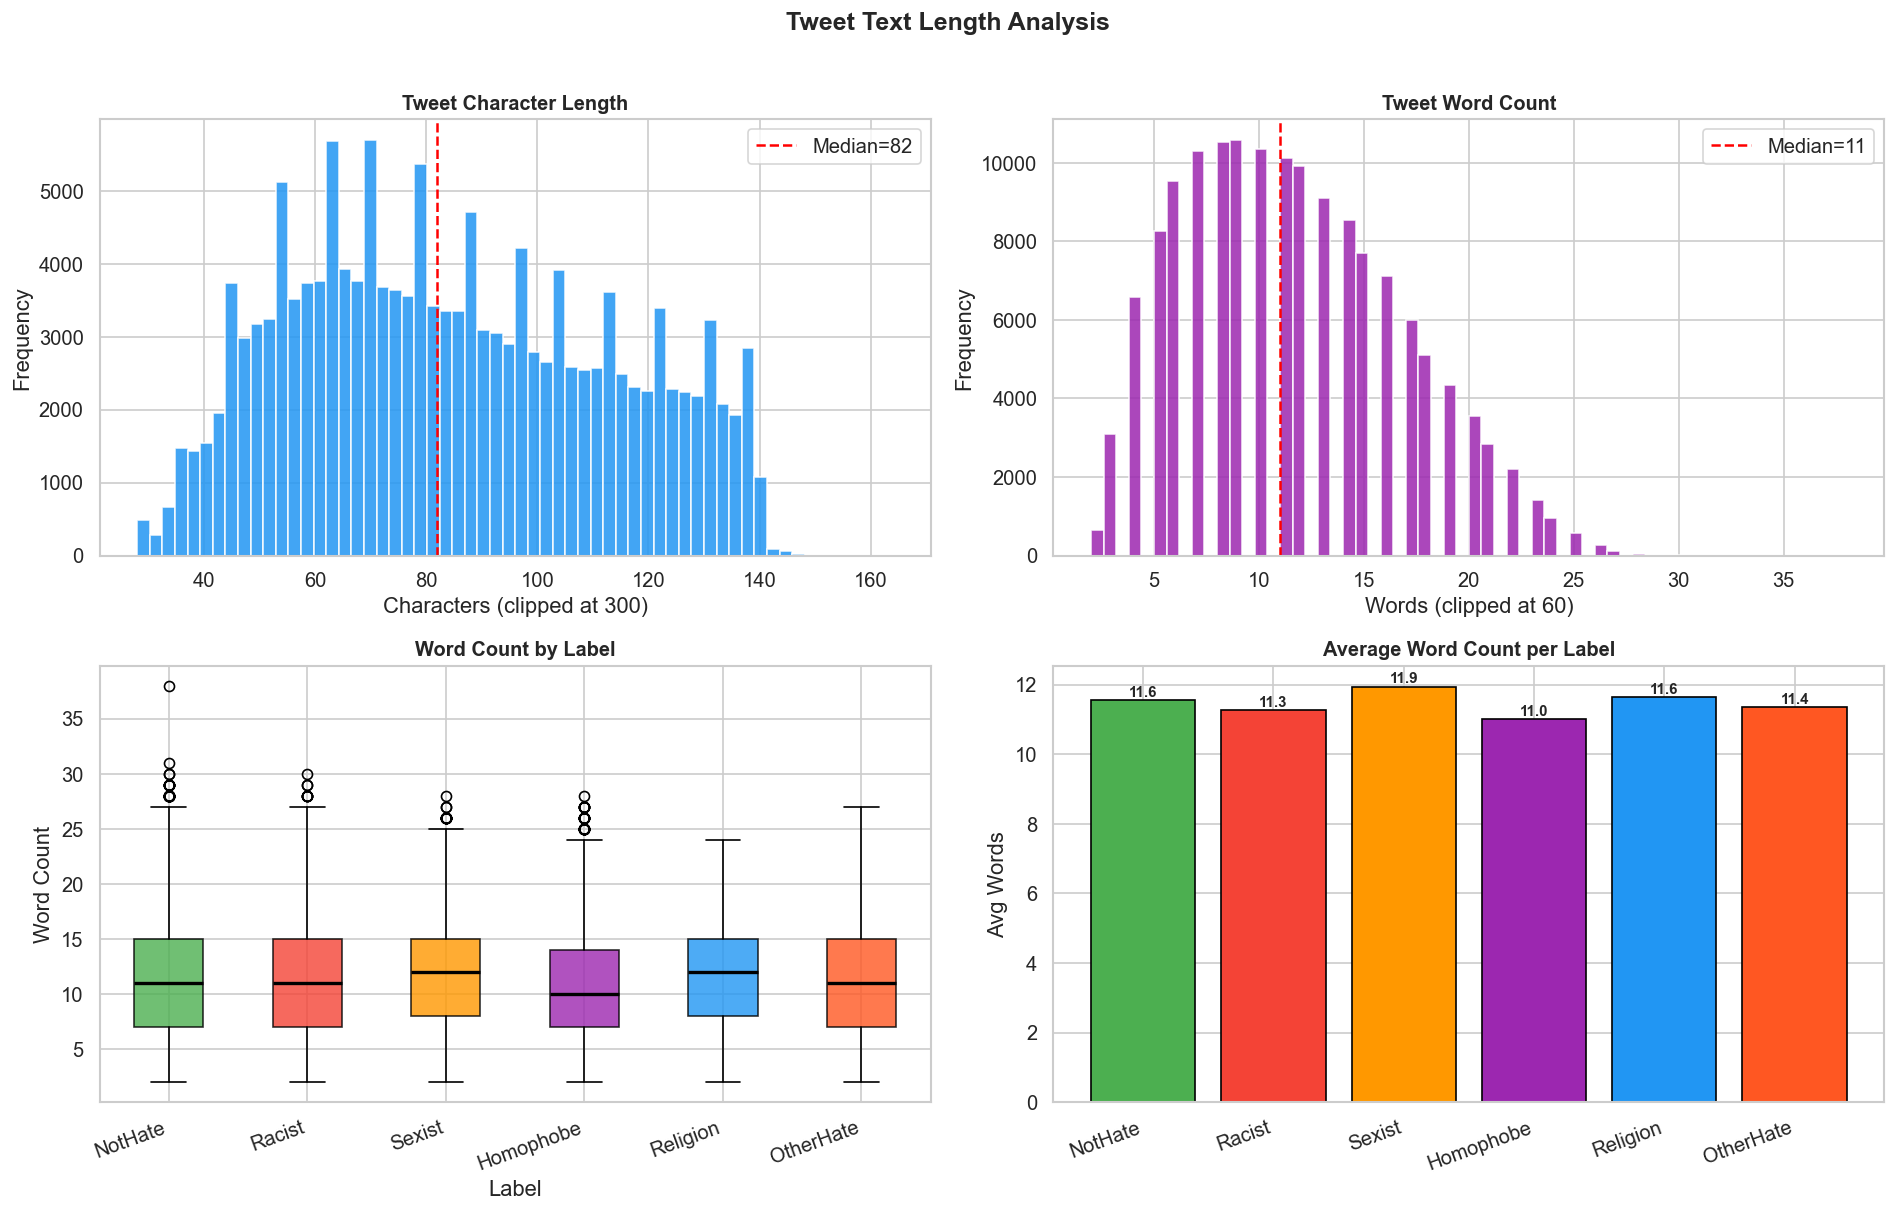

Saved → text_length_analysis.png


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ── (A) Char length distribution ──────────────────────────────────────
axes[0,0].hist(df['text_len'].clip(upper=300), bins=60, color='#2196F3',
               edgecolor='white', alpha=0.85)
axes[0,0].set_title('Tweet Character Length', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Characters (clipped at 300)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(df['text_len'].median(), color='red', linestyle='--', label=f'Median={df["text_len"].median():.0f}')
axes[0,0].legend()

# ── (B) Word count distribution ───────────────────────────────────────
axes[0,1].hist(df['word_count'].clip(upper=60), bins=60, color='#9C27B0',
               edgecolor='white', alpha=0.85)
axes[0,1].set_title('Tweet Word Count', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Words (clipped at 60)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(df['word_count'].median(), color='red', linestyle='--', label=f'Median={df["word_count"].median():.0f}')
axes[0,1].legend()

# ── (C) Word count by category (box) ─────────────────────────────────
order = [LABEL_MAP[i] for i in range(6)]
data_per_cat = [df[df['majority_label_str']==lbl]['word_count'].clip(upper=60) for lbl in order]
bp = axes[1,0].boxplot(data_per_cat, patch_artist=True, labels=order,
                       medianprops={'color':'black','linewidth':2})
for patch, color in zip(bp['boxes'], COLORS):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
axes[1,0].set_title('Word Count by Label', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Label')
axes[1,0].set_ylabel('Word Count')
axes[1,0].set_xticklabels(order, rotation=20, ha='right')

# ── (D) Avg word count per label ─────────────────────────────────────
avg_words = df.groupby('majority_label_str')['word_count'].mean().reindex(order)
axes[1,1].bar(avg_words.index, avg_words.values, color=COLORS, edgecolor='black')
for i, val in enumerate(avg_words.values):
    axes[1,1].text(i, val+0.1, f'{val:.1f}', ha='center', fontsize=9, fontweight='bold')
axes[1,1].set_title('Average Word Count per Label', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Avg Words')
axes[1,1].set_xticklabels(order, rotation=20, ha='right')

plt.suptitle('Tweet Text Length Analysis', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'text_length_analysis.png'), bbox_inches='tight')
plt.show()
print('Saved → text_length_analysis.png')

## 6. Word Clouds — Hate vs. Not-Hate

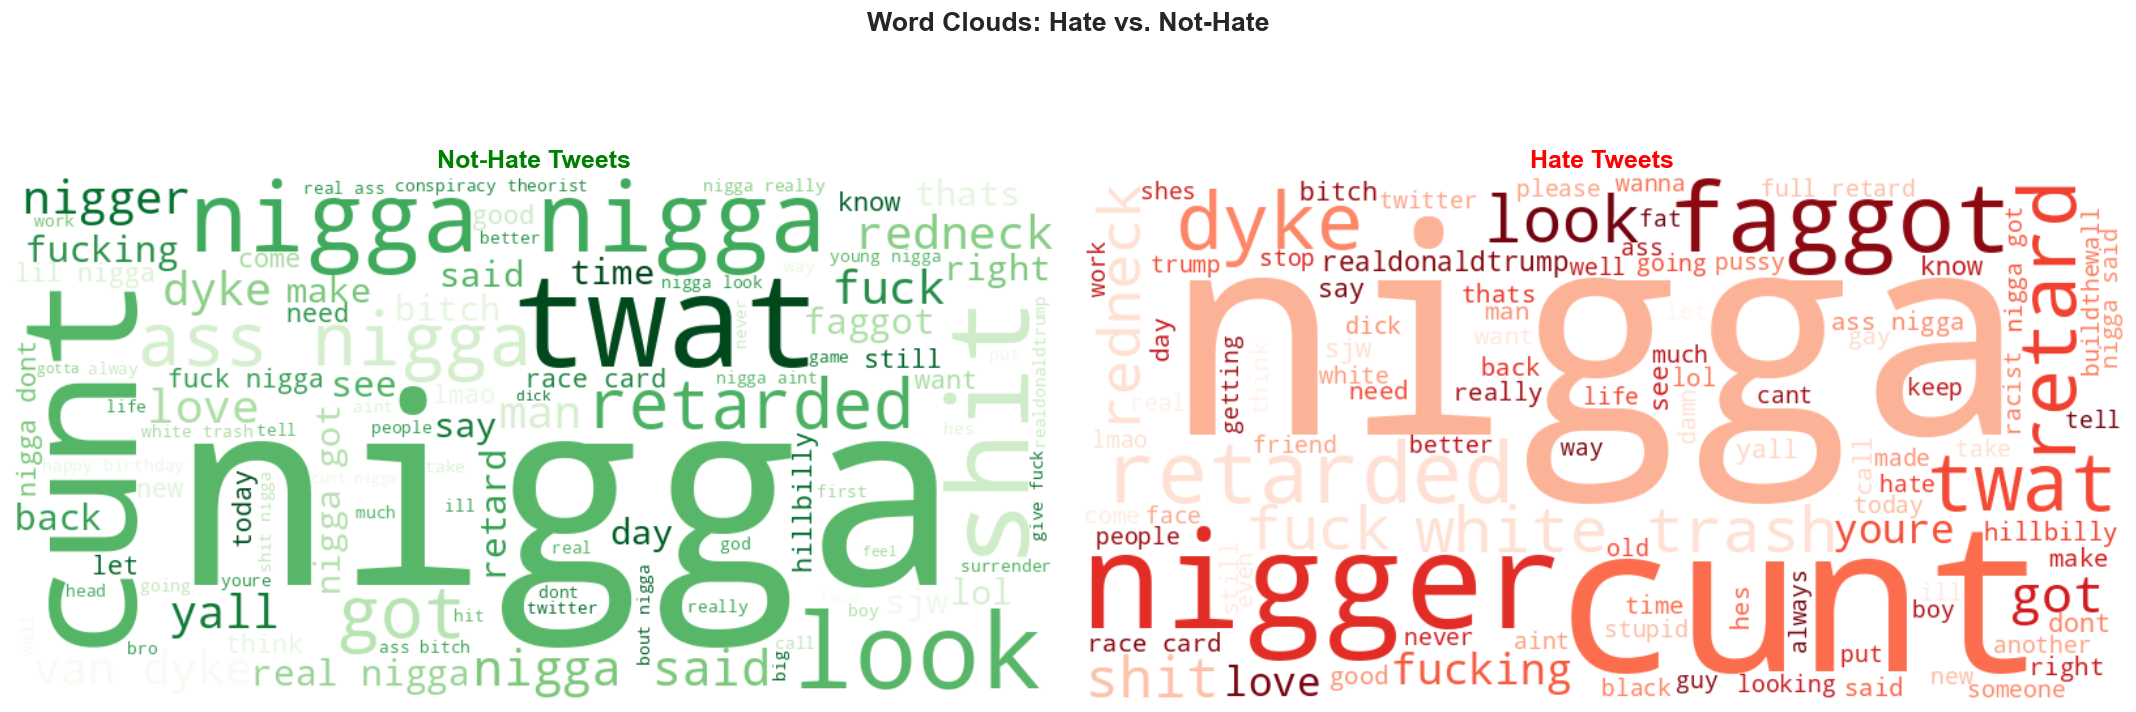

Saved → wordclouds_hate_vs_nothate.png


In [8]:
STOP = set(stopwords.words('english')) | {'https','co','t','amp','rt','u','im','like','just','get','go','one','gonna'}

def clean_text(texts):
    combined = ' '.join(texts).lower()
    combined = re.sub(r'http\S+', '', combined)
    combined = re.sub(r'[^a-z\s]', '', combined)
    tokens = [w for w in combined.split() if w not in STOP and len(w) > 2]
    return ' '.join(tokens)

not_hate_text = clean_text(df[~df['is_hate']]['tweet_text'].tolist())
hate_text     = clean_text(df[ df['is_hate']]['tweet_text'].tolist())

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

wc_not = WordCloud(width=800, height=400, background_color='white',
                   colormap='Greens', max_words=100,
                   contour_width=1, contour_color='green').generate(not_hate_text)
axes[0].imshow(wc_not, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Not-Hate Tweets', fontsize=15, fontweight='bold', color='green')

wc_hate = WordCloud(width=800, height=400, background_color='white',
                    colormap='Reds', max_words=100,
                    contour_width=1, contour_color='darkred').generate(hate_text)
axes[1].imshow(wc_hate, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Hate Tweets', fontsize=15, fontweight='bold', color='red')

plt.suptitle('Word Clouds: Hate vs. Not-Hate', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'wordclouds_hate_vs_nothate.png'), bbox_inches='tight')
plt.show()
print('Saved → wordclouds_hate_vs_nothate.png')

## 7. Top Words per Hate Category

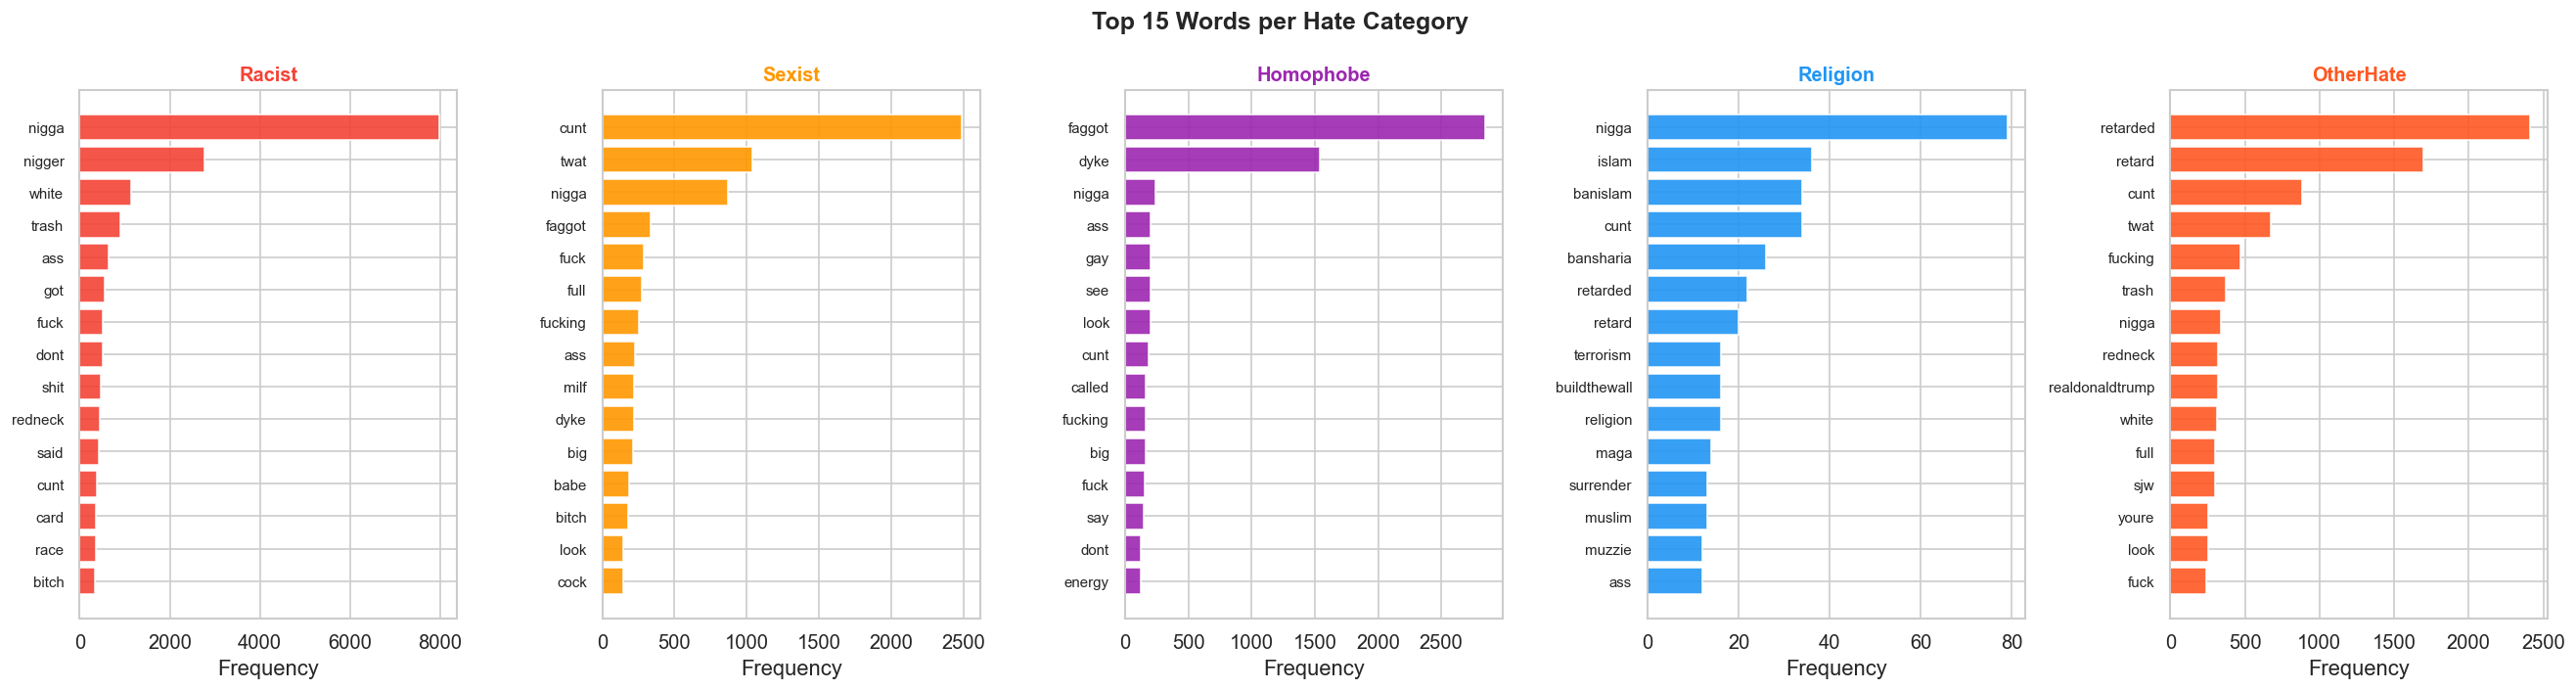

Saved → top_words_per_category.png


In [9]:
hate_labels = ['Racist','Sexist','Homophobe','Religion','OtherHate']
hate_colors = ['#F44336','#FF9800','#9C27B0','#2196F3','#FF5722']

fig, axes = plt.subplots(1, 5, figsize=(22, 6))

for ax, lbl, col in zip(axes, hate_labels, hate_colors):
    subset = df[df['majority_label_str'] == lbl]['tweet_text'].tolist()
    cleaned = clean_text(subset)
    freq = Counter(cleaned.split()).most_common(15)
    words, counts = zip(*freq) if freq else ([],[])
    ax.barh(list(words)[::-1], list(counts)[::-1], color=col, edgecolor='white', alpha=0.9)
    ax.set_title(lbl, fontsize=12, fontweight='bold', color=col)
    ax.set_xlabel('Frequency')
    ax.tick_params(axis='y', labelsize=9)

plt.suptitle('Top 15 Words per Hate Category', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'top_words_per_category.png'), bbox_inches='tight')
plt.show()
print('Saved → top_words_per_category.png')

## 8. Label Confusion / Co-occurrence Heatmap (Annotator Pairs)

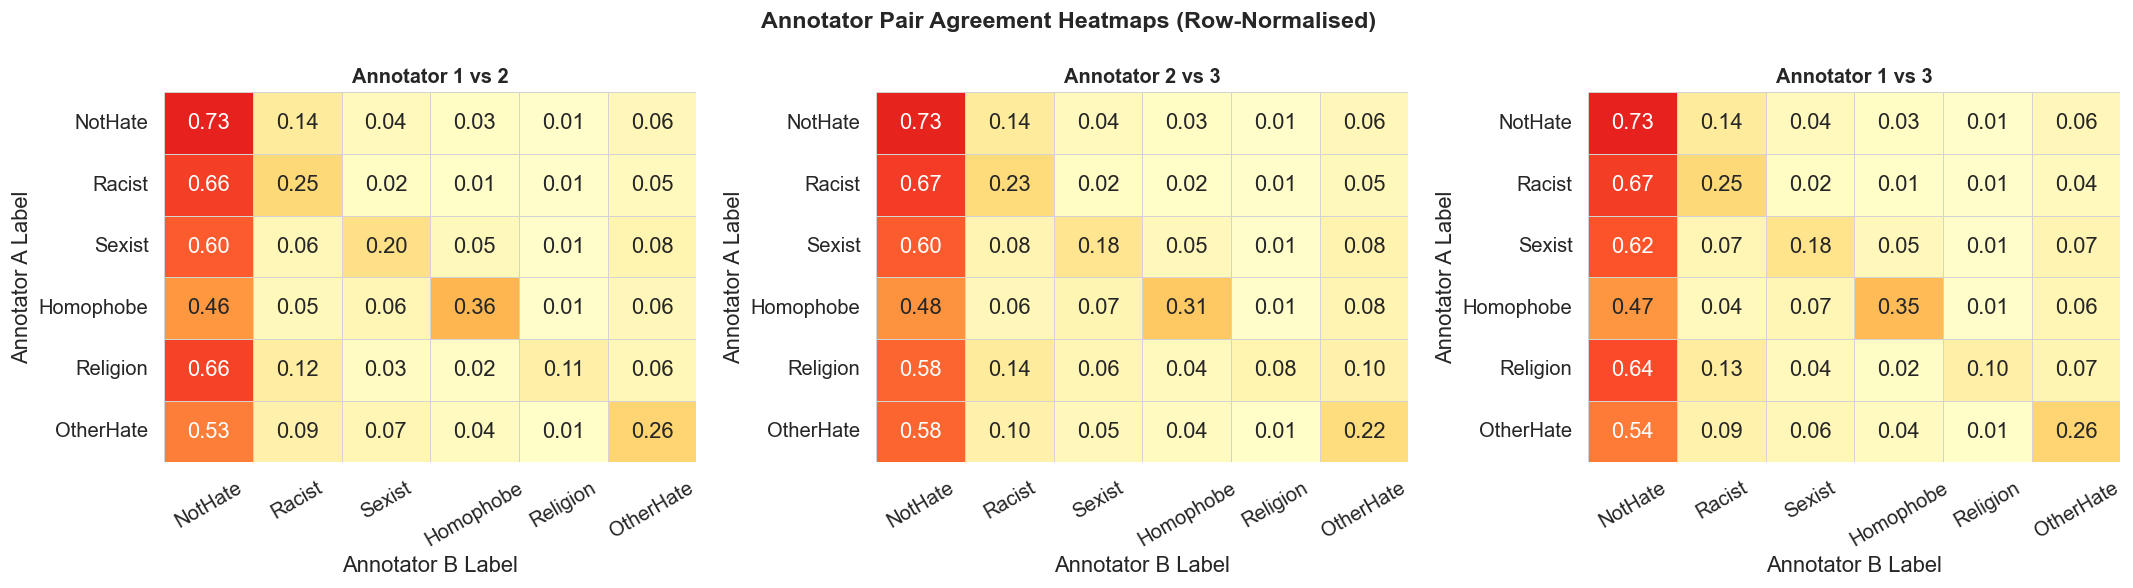

Saved → annotator_agreement_heatmap.png


In [10]:
from sklearn.metrics import confusion_matrix

label_names = [LABEL_MAP[i] for i in range(6)]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
pairs = [('label_0','label_1'), ('label_1','label_2'), ('label_0','label_2')]
pair_titles = ['Annotator 1 vs 2', 'Annotator 2 vs 3', 'Annotator 1 vs 3']

for ax, (a, b), title in zip(axes, pairs, pair_titles):
    cm = confusion_matrix(df[a], df[b], labels=list(range(6)))
    # Normalize rows
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', ax=ax,
                xticklabels=label_names, yticklabels=label_names,
                cmap='YlOrRd', linewidths=0.5, linecolor='lightgray',
                vmin=0, vmax=1, cbar=False)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Annotator B Label')
    ax.set_ylabel('Annotator A Label')
    ax.tick_params(axis='x', rotation=30)
    ax.tick_params(axis='y', rotation=0)

plt.suptitle('Annotator Pair Agreement Heatmaps (Row-Normalised)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'annotator_agreement_heatmap.png'), bbox_inches='tight')
plt.show()
print('Saved → annotator_agreement_heatmap.png')

## 9. OCR Text & Image Availability

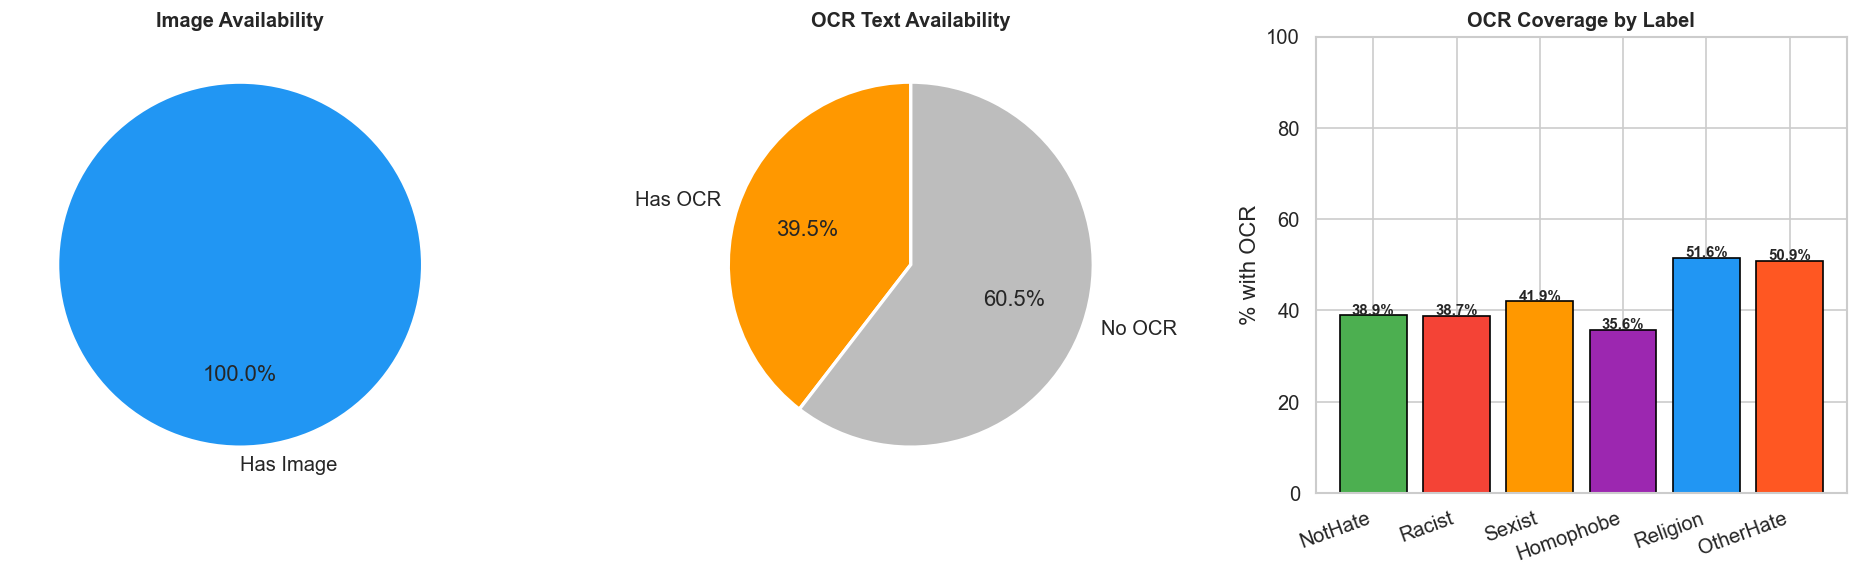

Saved → ocr_image_availability.png


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ── (A) Image availability ─────────────────────────────────────────────
img_has   = df['has_image'].sum()
img_miss  = len(df) - img_has
values_img = [img_has, img_miss] if img_miss > 0 else [img_has]
labels_img = ['Has Image','Missing'][:len(values_img)]
colors_img = ['#2196F3','#BDBDBD'][:len(values_img)]
axes[0].pie(values_img, labels=labels_img, colors=colors_img,
            autopct='%1.1f%%', startangle=90,
            wedgeprops={'edgecolor':'white','linewidth':2})
axes[0].set_title('Image Availability', fontsize=12, fontweight='bold')

# ── (B) OCR availability ───────────────────────────────────────────────
ocr_has  = df['has_ocr'].sum()
ocr_miss = len(df) - ocr_has
axes[1].pie([ocr_has, ocr_miss], labels=['Has OCR','No OCR'],
            colors=['#FF9800','#BDBDBD'],
            autopct='%1.1f%%', startangle=90,
            wedgeprops={'edgecolor':'white','linewidth':2})
axes[1].set_title('OCR Text Availability', fontsize=12, fontweight='bold')

# ── (C) OCR availability by label ────────────────────────────────────
ocr_by_lbl = df.groupby('majority_label_str')['has_ocr'].mean().reindex(
    [LABEL_MAP[i] for i in range(6)])*100
axes[2].bar(ocr_by_lbl.index, ocr_by_lbl.values, color=COLORS, edgecolor='black')
for i, val in enumerate(ocr_by_lbl.values):
    axes[2].text(i, val+0.3, f'{val:.1f}%', ha='center', fontsize=9, fontweight='bold')
axes[2].set_title('OCR Coverage by Label', fontsize=12, fontweight='bold')
axes[2].set_ylabel('% with OCR')
axes[2].set_xticklabels(ocr_by_lbl.index, rotation=20, ha='right')
axes[2].set_ylim(0, 100)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'ocr_image_availability.png'), bbox_inches='tight')
plt.show()
print('Saved → ocr_image_availability.png')

## 10. Hate Speech Keyword Analysis

Counting keyword hits (may take ~30 s)...


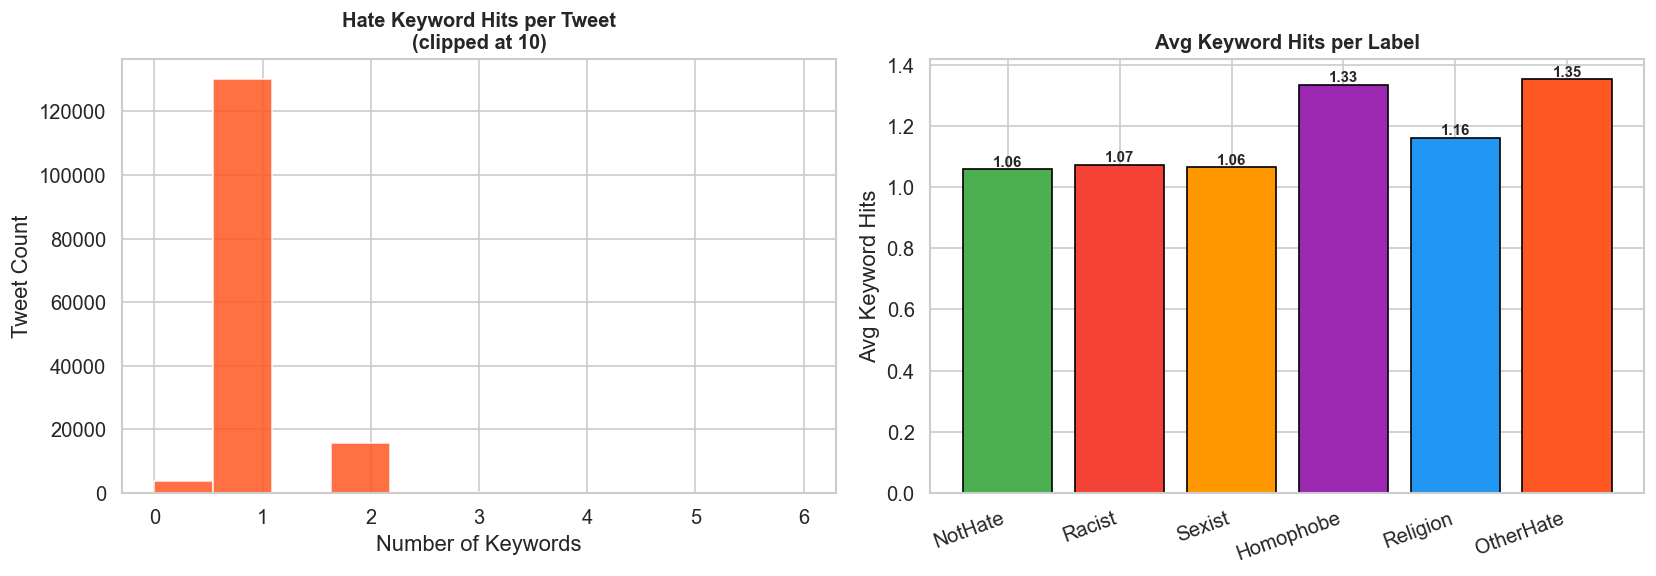

Total keywords in list: 86
Tweets with ≥1 keyword: 146,156 (97.6%)
Saved → keyword_analysis.png


In [13]:
with open(os.path.join(BASE, 'hatespeech_keywords.txt')) as f:
    keywords = [line.strip().lower() for line in f if line.strip()]

# Count keyword hits per tweet
def count_keywords(text):
    t = text.lower()
    return sum(1 for kw in keywords if kw in t)

print('Counting keyword hits (may take ~30 s)...')
df['kw_hits'] = df['tweet_text'].apply(count_keywords)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of keyword hits
axes[0].hist(df['kw_hits'].clip(upper=10), bins=11,
             color='#FF5722', edgecolor='white', alpha=0.85)
axes[0].set_title('Hate Keyword Hits per Tweet\n(clipped at 10)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Keywords')
axes[0].set_ylabel('Tweet Count')

# Avg keyword hits by label
kw_by_lbl = df.groupby('majority_label_str')['kw_hits'].mean().reindex(
    [LABEL_MAP[i] for i in range(6)])
axes[1].bar(kw_by_lbl.index, kw_by_lbl.values, color=COLORS, edgecolor='black')
for i, val in enumerate(kw_by_lbl.values):
    axes[1].text(i, val+0.01, f'{val:.2f}', ha='center', fontsize=9, fontweight='bold')
axes[1].set_title('Avg Keyword Hits per Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Avg Keyword Hits')
axes[1].set_xticklabels(kw_by_lbl.index, rotation=20, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'keyword_analysis.png'), bbox_inches='tight')
plt.show()

print(f'Total keywords in list: {len(keywords)}')
print(f'Tweets with ≥1 keyword: {(df["kw_hits"]>0).sum():,} ({(df["kw_hits"]>0).mean()*100:.1f}%)')
print('Saved → keyword_analysis.png')

## 11. Heatmap — Category × Split

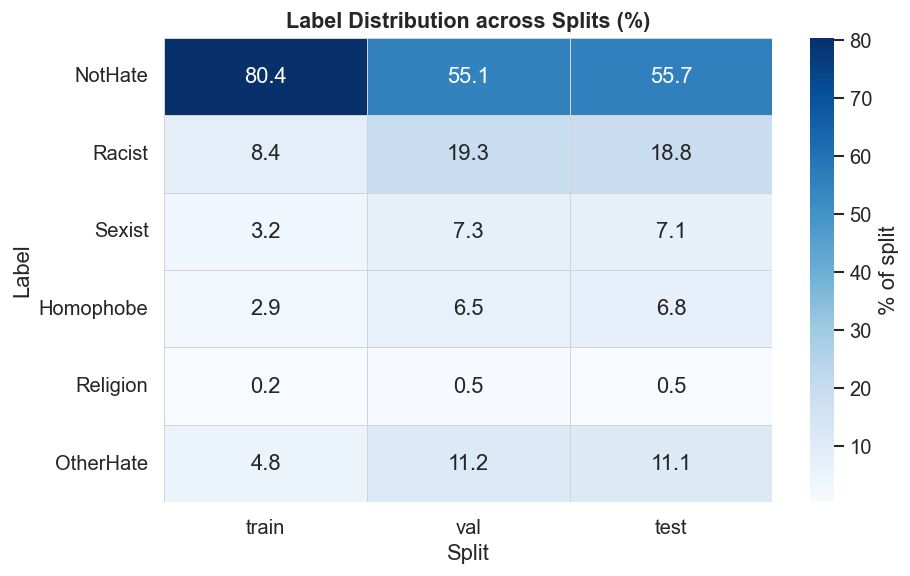

Saved → label_vs_split_heatmap.png


In [14]:
cross = pd.crosstab(df['majority_label_str'], df['split'],
                    normalize='columns') * 100
cross = cross.reindex([LABEL_MAP[i] for i in range(6)], axis=0)
cross = cross.reindex(['train','val','test'], axis=1)

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(cross, annot=True, fmt='.1f', cmap='Blues',
            linewidths=0.5, linecolor='lightgray',
            cbar_kws={'label': '% of split'}, ax=ax)
ax.set_title('Label Distribution across Splits (%)', fontsize=13, fontweight='bold')
ax.set_xlabel('Split')
ax.set_ylabel('Label')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'label_vs_split_heatmap.png'), bbox_inches='tight')
plt.show()
print('Saved → label_vs_split_heatmap.png')

## 12. Summary Statistics

In [15]:
print('='*60)
print('         MMHS150K EDA — SUMMARY')
print('='*60)
print(f'Total tweets         : {len(df):,}')
print(f'Train / Val / Test   : {len(splits["train"]):,} / {len(splits["val"]):,} / {len(splits["test"]):,}')
print()
print('── Class Counts (Majority Vote) ──')
for i in range(6):
    cnt = (df['majority_label'] == i).sum()
    print(f'  {LABEL_MAP[i]:<12}: {cnt:>7,}  ({cnt/len(df)*100:5.1f}%)')
print()
print('── Text Statistics ──')
print(f'  Avg chars (all)  : {df["text_len"].mean():.1f}')
print(f'  Avg words (all)  : {df["word_count"].mean():.1f}')
print(f'  Avg words (hate) : {df[df["is_hate"]]["word_count"].mean():.1f}')
print(f'  Avg words (safe) : {df[~df["is_hate"]]["word_count"].mean():.1f}')
print()
print('── Annotator Agreement ──')
for k, v in df['agreement'].value_counts().items():
    print(f'  {k:<30}: {v:>7,}  ({v/len(df)*100:5.1f}%)')
print()
print('── Modality Coverage ──')
print(f'  Has image : {df["has_image"].sum():>7,}  ({df["has_image"].mean()*100:.1f}%)')
print(f'  Has OCR   : {df["has_ocr"].sum():>7,}  ({df["has_ocr"].mean()*100:.1f}%)')
print('='*60)
print(f'All charts saved to: {OUT_DIR}')

         MMHS150K EDA — SUMMARY
Total tweets         : 149,823
Train / Val / Test   : 134,823 / 5,000 / 10,000

── Class Counts (Majority Vote) ──
  NotHate     : 116,789  ( 78.0%)
  Racist      :  14,182  (  9.5%)
  Sexist      :   5,376  (  3.6%)
  Homophobe   :   4,927  (  3.3%)
  Religion    :     353  (  0.2%)
  OtherHate   :   8,196  (  5.5%)

── Text Statistics ──
  Avg chars (all)  : 84.7
  Avg words (all)  : 11.5
  Avg words (hate) : 11.4
  Avg words (safe) : 11.6

── Annotator Agreement ──
  Partial Agreement (2/3)       :  76,097  ( 50.8%)
  Full Agreement (3/3)          :  62,027  ( 41.4%)
  No Agreement (1-1-1)          :  11,699  (  7.8%)

── Modality Coverage ──
  Has image : 149,823  (100.0%)
  Has OCR   :  59,252  (39.5%)
All charts saved to: /Users/sankalpssss/Desktop/Keerthan_thesis/Code/EDA
